In [8]:
%%capture
!pip install mediapipe

### Required Libraries

In [27]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import joblib
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')

from PIL import Image, ImageDraw, ImageFont
import shutil
from moviepy.video.io.VideoFileClip import VideoFileClip

from google.colab.patches import cv2_imshow

from mediapipe.python.solutions import face_mesh

In [10]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [11]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [12]:
def get_features(images_path_list):
  faceModule = mediapipe.solutions.face_mesh
  x_final = []
  y_final = []
  label = []
  nose = (0,0)
  for img in images_path_list:
    # loading image and its correspinding mat file
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        # loading the image
        image = cv2.imread(img)
        image = cv2.resize(image, (450,450))

        x_values = []
        y_values = []

        # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if results.multi_face_landmarks != None:
          # looping over the faces in the image
          for face in results.multi_face_landmarks:
              for idx, landmark in enumerate(face.landmark):
                  x = landmark.x
                  y = landmark.y
                  # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                  shape = image.shape

                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])

                  if idx==1:
                    nose = (relative_x, relative_y)


                  x_values.append(relative_x)
                  y_values.append(relative_y)

          x_final.append(x_values)
          y_final.append(y_values)

  return x_final, y_final, nose

In [7]:
model = joblib.load('svm_model.pkl')

## Test Model on images

In [15]:
import glob

folder_path = '/content/AFLW2000/'
images = glob.glob(folder_path + '*.jpg')
images[:5]

['/content/AFLW2000/image00263.jpg',
 '/content/AFLW2000/image00498.jpg',
 '/content/AFLW2000/image02597.jpg',
 '/content/AFLW2000/image02633.jpg',
 '/content/AFLW2000/image03440.jpg']

In [9]:
def test_model_images(image_path, show=False):
  image = cv2.imread(image_path)
  resized_img = cv2.resize(image, (450,450))

  x_final, y_final, noses = get_features([image_path])
  x_final = np.array(x_final).reshape(1,-1)
  y_final = np.array(y_final).reshape(1,-1)

  tdx, tdy = noses

  data = np.concatenate((x_final, y_final), axis=1)
  pred = model.predict(data)
  pitch,yaw,roll = pred[:,0], pred[:,1], pred[:,2]

  new_img = draw_axis(resized_img,pitch,yaw,roll, tdx=tdx, tdy=tdy)
  # if show:
  # # cv2_imshow(draw_axis(resized_img,pitch,yaw,roll))
  #   cv2_imshow(new_img)

  return new_img

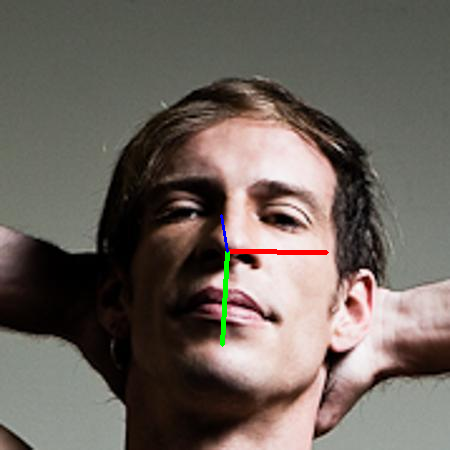

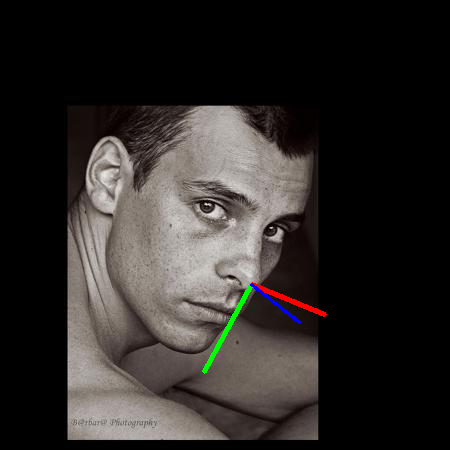

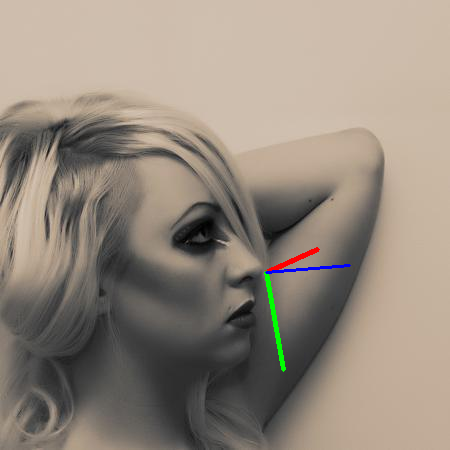

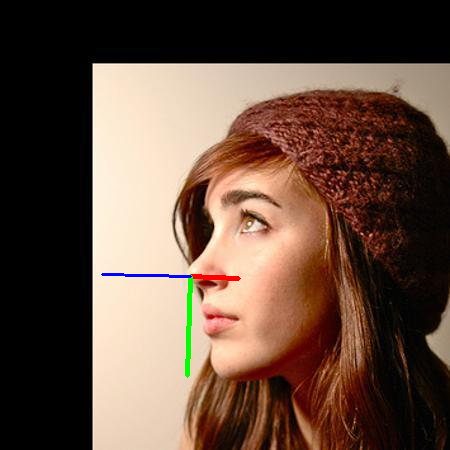

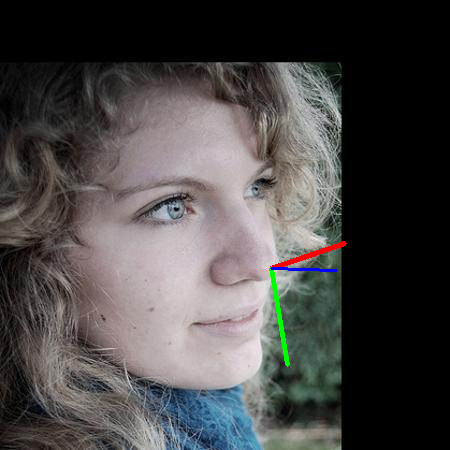

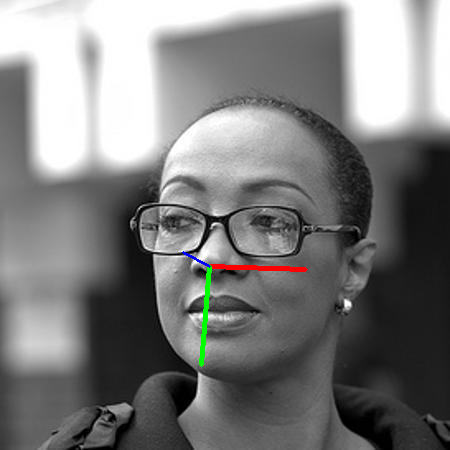

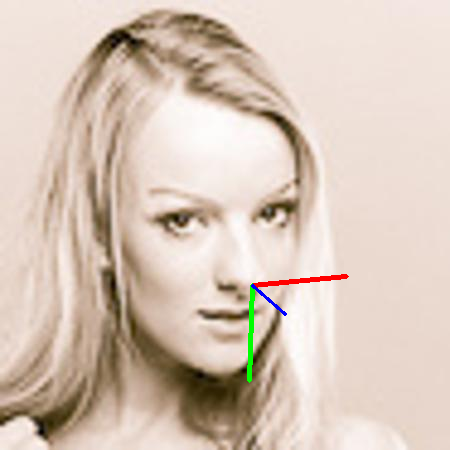

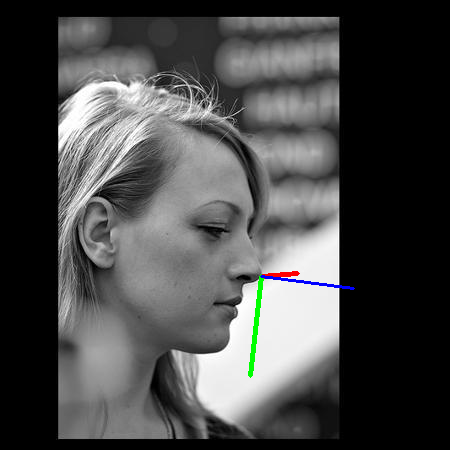

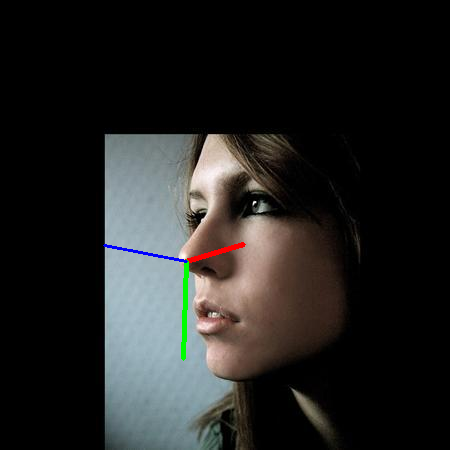

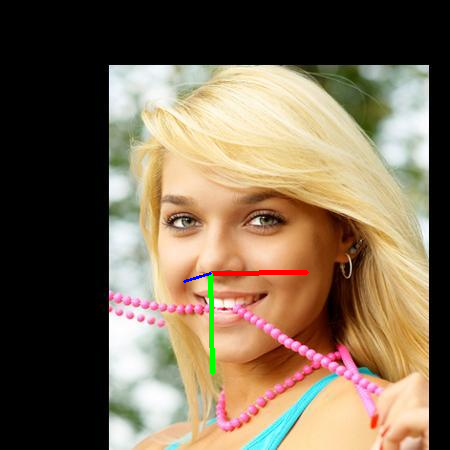

In [ ]:
for _ in range(10):
  test_model_images(np.random.choice(images), True)

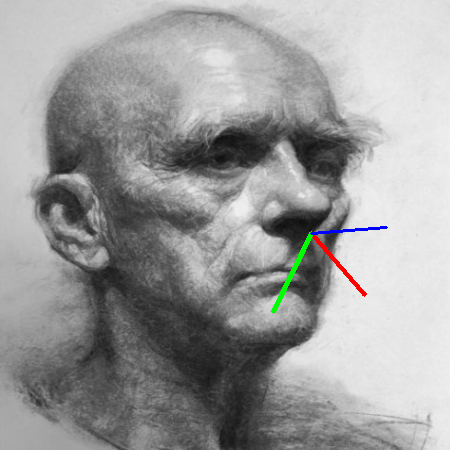

In [ ]:
test_model_images('test2.PNG')

array([[[123, 179, 220],
        [123, 179, 220],
        [123, 179, 220],
        ...,
        [ 62,  89, 111],
        [ 62,  89, 111],
        [ 62,  89, 111]],

       [[123, 179, 220],
        [123, 179, 220],
        [123, 179, 220],
        ...,
        [ 62,  89, 111],
        [ 62,  89, 111],
        [ 62,  89, 111]],

       [[129, 185, 226],
        [129, 185, 226],
        [129, 185, 226],
        ...,
        [ 88, 120, 144],
        [ 88, 121, 144],
        [ 88, 121, 144]],

       ...,

       [[  6,  20,  37],
        [  6,  20,  37],
        [  5,  19,  36],
        ...,
        [ 12,  29,  43],
        [ 12,  29,  44],
        [ 12,  29,  44]],

       [[  5,  19,  36],
        [  5,  19,  36],
        [  5,  18,  36],
        ...,
        [ 12,  29,  44],
        [ 12,  29,  44],
        [ 12,  29,  44]],

       [[  5,  19,  36],
        [  5,  19,  36],
        [  5,  18,  35],
        ...,
        [ 12,  29,  44],
        [ 12,  29,  44],
        [ 12,  29,  44]]], dtype=uint8)
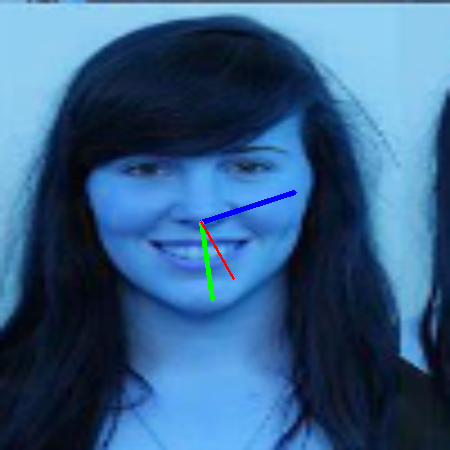

In [ ]:
test_model_images('test3.PNG', True)

## Model on videos

#### First Trial

In [26]:
from PIL import Image, ImageDraw, ImageFont
import shutil
from moviepy.video.io.VideoFileClip import VideoFileClip

In [11]:
# Convert video to frames
vidcap = cv2.VideoCapture('/content/3 Cute Instagram Pose Ideas!.mp4')
success, image = vidcap.read()

In [ ]:
shutil.rmtree('frames')

In [12]:
count = 0
os.mkdir('frames')

while success:
    cv2.imwrite(os.path.join("frames/frame%d.jpg" % count), image)  # save frame as JPEG file
    success, image = vidcap.read()
    count += 1

In [13]:
video = VideoFileClip("/content/3 Cute Instagram Pose Ideas!.mp4")
audio = video.audio.write_audiofile("audio.wav")

# Close the video file
video.close()

MoviePy - Writing audio in audio.wav


MoviePy - Done.


In [43]:
shutil.rmtree('/content/captioned_frames')

In [44]:
os.mkdir('captioned_frames')

destroy_lst = []
for i in range(count):
    img_path = os.path.join("frames/frame%d.jpg" % i)
    try:
      new_frame = test_model_images(img_path)
      new_frame = cv2.cvtColor(new_frame, cv2.COLOR_BGR2RGB)
      image = Image.fromarray(new_frame)
      image.save(os.path.join("captioned_frames/frame%d.jpg" % i))
    except:
      shutil.copy(img_path, "captioned_frames/frame%d.jpg" % i)

In [45]:
len(os.listdir('captioned_frames/')), count

(354, 354)

In [46]:
lst = os.listdir('/content/captioned_frames')
sorted_filenames = sorted(lst, key=lambda x: int(x.split('frame')[1].split('.')[0]))
print(sorted_filenames)

['frame0.jpg', 'frame1.jpg', 'frame2.jpg', 'frame3.jpg', 'frame4.jpg', 'frame5.jpg', 'frame6.jpg', 'frame7.jpg', 'frame8.jpg', 'frame9.jpg', 'frame10.jpg', 'frame11.jpg', 'frame12.jpg', 'frame13.jpg', 'frame14.jpg', 'frame15.jpg', 'frame16.jpg', 'frame17.jpg', 'frame18.jpg', 'frame19.jpg', 'frame20.jpg', 'frame21.jpg', 'frame22.jpg', 'frame23.jpg', 'frame24.jpg', 'frame25.jpg', 'frame26.jpg', 'frame27.jpg', 'frame28.jpg', 'frame29.jpg', 'frame30.jpg', 'frame31.jpg', 'frame32.jpg', 'frame33.jpg', 'frame34.jpg', 'frame35.jpg', 'frame36.jpg', 'frame37.jpg', 'frame38.jpg', 'frame39.jpg', 'frame40.jpg', 'frame41.jpg', 'frame42.jpg', 'frame43.jpg', 'frame44.jpg', 'frame45.jpg', 'frame46.jpg', 'frame47.jpg', 'frame48.jpg', 'frame49.jpg', 'frame50.jpg', 'frame51.jpg', 'frame52.jpg', 'frame53.jpg', 'frame54.jpg', 'frame55.jpg', 'frame56.jpg', 'frame57.jpg', 'frame58.jpg', 'frame59.jpg', 'frame60.jpg', 'frame61.jpg', 'frame62.jpg', 'frame63.jpg', 'frame64.jpg', 'frame65.jpg', 'frame66.jpg', 'fra

In [47]:
from moviepy.editor import *

# Set the directory where the frames are stored
frame_dir = "/content/captioned_frames"

# Set the path to the audio file
audio_path = "audio.wav"


# Set the frame rate of the output video
fps = 30

# Load the audio file
audio = AudioFileClip(audio_path)

# Create a list of ImageClips for each frame
clips = [ImageClip(os.path.join(frame_dir, frame)).set_duration(1/fps) for frame in sorted_filenames]

# Concatenate the ImageClips to create a video
video = concatenate_videoclips(clips, method="compose")

# Set the audio for the video
video = video.set_audio(audio)

# Set the output video file name
output_file = "output.mp4"

# Write the video to file
video.write_videofile(output_file, fps=fps, codec="libx264")

Moviepy - Building video output.mp4.
MoviePy - Writing audio in outputTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4


In [5]:
from IPython.display import HTML
from base64 import b64encode

def display_video(video_path):
  mp4 = open(video_path, "rb").read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML(f"""
  <video width=400 controls><source src="{data_url}" type="video/mp4">
  </video>""")

In [6]:
display_video('/content/3 Cute Instagram Pose Ideas!.mp4')

In [48]:
from IPython.display import HTML
from base64 import b64encode

video_path = '/content/output.mp4'
# video_path = '/content/3 Cute Instagram Pose Ideas!.mp4'
mp4 = open(video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=400 controls><source src="{data_url}" type="video/mp4">
</video>""")

## Another Model

In [14]:
model = joblib.load('model.joblib')
scaler = joblib.load('min_max_scaler.joblib')
pca = joblib.load('pca.joblib')

In [21]:
def process_input(X_data):
  x_data_transformed = scaler.transform(X_data)
  pca_result = pca.transform(x_data_transformed)
  return pca_result

In [76]:
def test_model_images(image_path, show=False):
  image = cv2.imread(image_path)
  resized_img = cv2.resize(image, (450,450))

  try:
    x_final, y_final, noses = get_features([image_path])
    x_final = np.array(x_final).reshape(1,-1)
    y_final = np.array(y_final).reshape(1,-1)

    tdx, tdy = noses

    data = np.concatenate((x_final, y_final), axis=1)
    data = process_input(data)


    pred = model.predict(data)
    pitch,yaw,roll = pred[:,0], pred[:,1], pred[:,2]

    new_img = draw_axis(resized_img,pitch,yaw,roll, tdx=tdx, tdy=tdy)

  except:
    return resized_img
  # if show:
  # # cv2_imshow(draw_axis(resized_img,pitch,yaw,roll))
  #   cv2_imshow(new_img)

  return new_img

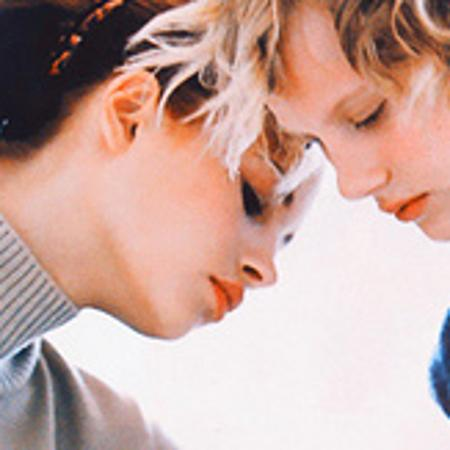

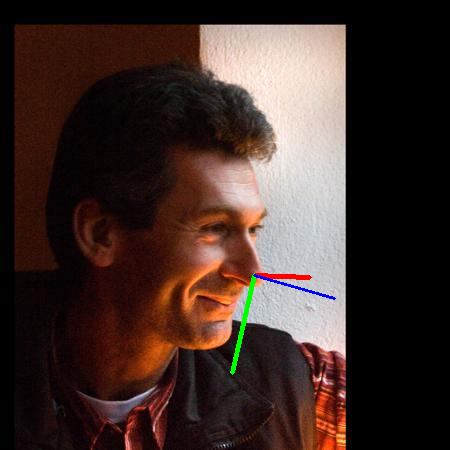

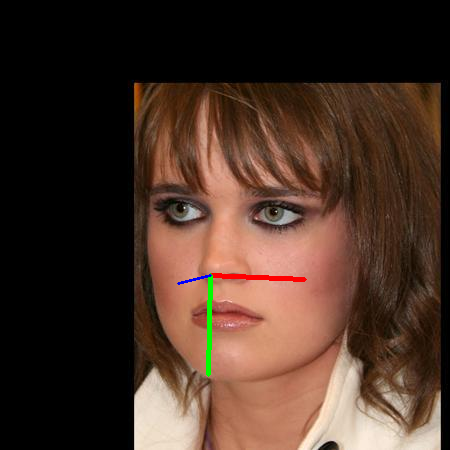

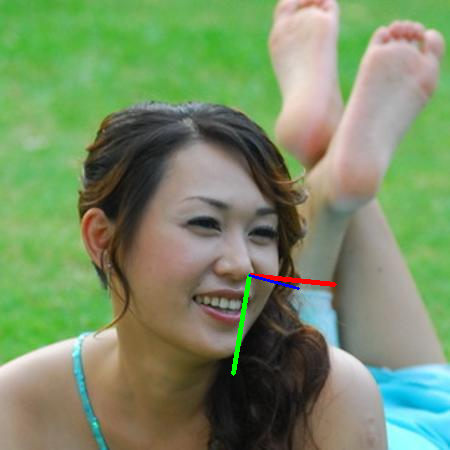

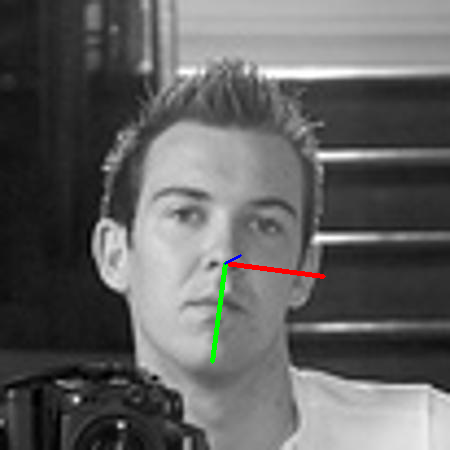

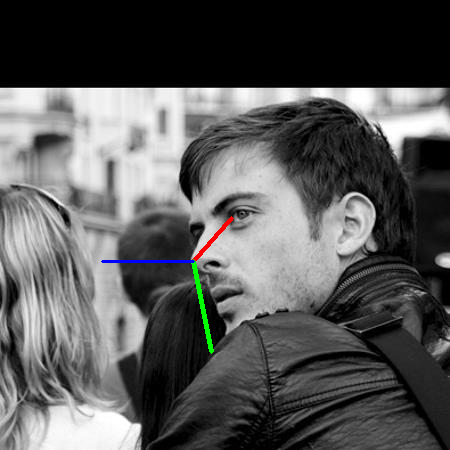

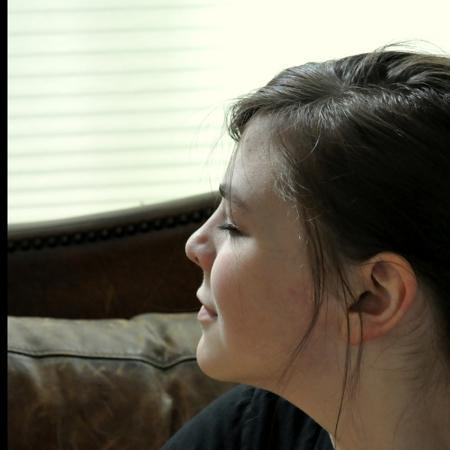

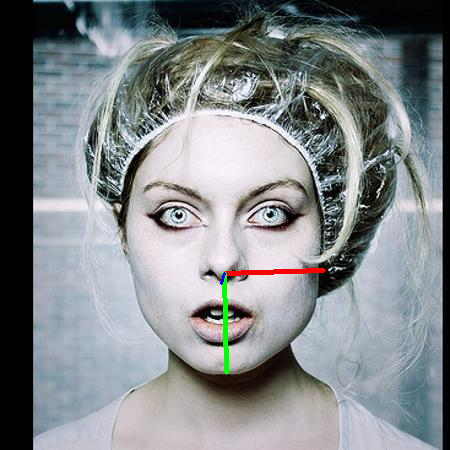

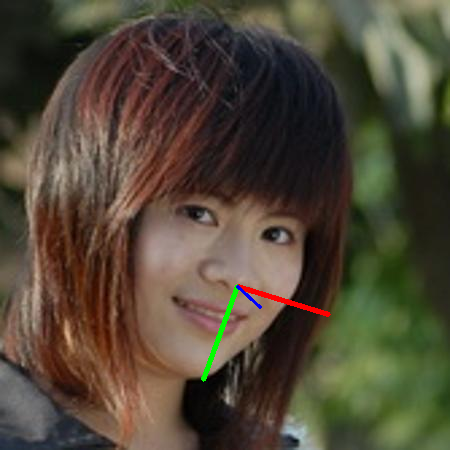

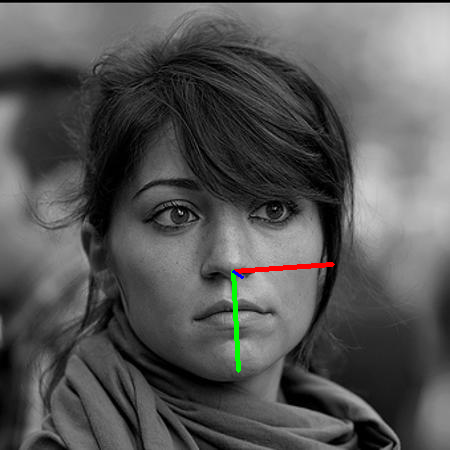

In [84]:
for _ in range(10):
  cv2_imshow(test_model_images(np.random.choice(images), True))

In [145]:
# Convert video to frames
video_path = '/content/180148356_290167385935566_1151129650006275323_n.mp4'
vidcap = cv2.VideoCapture(video_path)
success, image = vidcap.read()

In [146]:
shutil.rmtree('frames')

In [147]:
count = 0
os.mkdir('frames')

while success:
    cv2.imwrite(os.path.join("frames/frame%d.jpg" % count), image)  # save frame as JPEG file
    success, image = vidcap.read()
    count += 1

In [148]:
video = VideoFileClip(video_path)
audio = video.audio.write_audiofile("audio.wav")

# Close the video file
video.close()

MoviePy - Writing audio in audio.wav


MoviePy - Done.


In [149]:
shutil.rmtree('/content/captioned_frames')

In [150]:
os.mkdir('captioned_frames')

destroy_lst = []
for i in range(count):
    img_path = os.path.join("frames/frame%d.jpg" % i)
    try:
      new_frame = test_model_images(img_path)
      new_frame = cv2.cvtColor(new_frame, cv2.COLOR_BGR2RGB)
      image = Image.fromarray(new_frame)
      image.save(os.path.join("captioned_frames/frame%d.jpg" % i))
    except:
      shutil.copy(img_path, "captioned_frames/frame%d.jpg" % i)

In [151]:
len(os.listdir('captioned_frames/')), count

(777, 777)

In [152]:
lst = os.listdir('/content/captioned_frames')
sorted_filenames = sorted(lst, key=lambda x: int(x.split('frame')[1].split('.')[0]))
print(sorted_filenames)

['frame0.jpg', 'frame1.jpg', 'frame2.jpg', 'frame3.jpg', 'frame4.jpg', 'frame5.jpg', 'frame6.jpg', 'frame7.jpg', 'frame8.jpg', 'frame9.jpg', 'frame10.jpg', 'frame11.jpg', 'frame12.jpg', 'frame13.jpg', 'frame14.jpg', 'frame15.jpg', 'frame16.jpg', 'frame17.jpg', 'frame18.jpg', 'frame19.jpg', 'frame20.jpg', 'frame21.jpg', 'frame22.jpg', 'frame23.jpg', 'frame24.jpg', 'frame25.jpg', 'frame26.jpg', 'frame27.jpg', 'frame28.jpg', 'frame29.jpg', 'frame30.jpg', 'frame31.jpg', 'frame32.jpg', 'frame33.jpg', 'frame34.jpg', 'frame35.jpg', 'frame36.jpg', 'frame37.jpg', 'frame38.jpg', 'frame39.jpg', 'frame40.jpg', 'frame41.jpg', 'frame42.jpg', 'frame43.jpg', 'frame44.jpg', 'frame45.jpg', 'frame46.jpg', 'frame47.jpg', 'frame48.jpg', 'frame49.jpg', 'frame50.jpg', 'frame51.jpg', 'frame52.jpg', 'frame53.jpg', 'frame54.jpg', 'frame55.jpg', 'frame56.jpg', 'frame57.jpg', 'frame58.jpg', 'frame59.jpg', 'frame60.jpg', 'frame61.jpg', 'frame62.jpg', 'frame63.jpg', 'frame64.jpg', 'frame65.jpg', 'frame66.jpg', 'fra

In [153]:
from moviepy.editor import *

# Set the directory where the frames are stored
frame_dir = "/content/captioned_frames"

# Set the path to the audio file
audio_path = "audio.wav"


# Set the frame rate of the output video
fps = 30

# Load the audio file
audio = AudioFileClip(audio_path)

# Create a list of ImageClips for each frame
clips = [ImageClip(os.path.join(frame_dir, frame)).set_duration(1/fps) for frame in sorted_filenames]

# Concatenate the ImageClips to create a video
video = concatenate_videoclips(clips, method="compose")

# Set the audio for the video
video = video.set_audio(audio)

# Set the output video file name
output_file = "output.mp4"

# Write the video to file
video.write_videofile(output_file, fps=fps, codec="libx264")

Moviepy - Building video output.mp4.
MoviePy - Writing audio in outputTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4


In [154]:
display_video('/content/output.mp4')